# Interoperability with Python: the `PyCall` package

Coming from the Python ecosystem, the range of packages available in Julia can seem somewhat limited.
This is offset, however, by the ease of calling out to packages written in other languages from within Julia.

In particular, Python interoperability is very easy, thanks to the [`PyCall` package](https://github.com/stevengj/PyCall.jl). This is loaded with

In [1]:
using PyCall

`PyCall` has a high-level interface that is designed so that the "transport" between Julia and Python is transparent from the user's point of view. For example, to import the Python `math` module, we do

In [2]:
@pyimport math

In [3]:
macroexpand(:(@pyimport math))

quote  # /Users/dsanders/.julia/v0.3/PyCall/src/PyCall.jl, line 362:
    if PyCall.!(PyCall.isdefined(:math)) # line 363:
        const math = PyCall.pywrap(PyCall.pyimport("math"))
    else  # line 364:
        if PyCall.!(PyCall.isa(math,PyCall.Module)) # line 365:
            PyCall.error("@pyimport: ",:math," already defined")
        end
    end # line 367:
    PyCall.nothing
end

We can now mix and match Python calls, labelled by the `math.` qualifier, and Julia calls:

In [3]:
math.sin(0.3*math.pi) - sin(0.3*pi) 

-1.1102230246251565e-16

Array objects are automatically converted:

In [9]:
@pyimport numpy.random as nprandom
nprandom.rand(3,4)

3x4 Array{Float64,2}:
 0.130444  0.9004     0.364677  0.321106
 0.107789  0.0264795  0.369139  0.215905
 0.723455  0.31165    0.110962  0.123888

Let's define a Julia function:

In [4]:
objective = x -> cos(x) - x

(anonymous function)

This is the Julia syntax for an anonymous function (like `lambda` in Python).

In [5]:
objective(3)

-3.989992496600445

We can pass this Julia function to a Python module:

In [6]:
?so.newton

LoadError: so not defined
while loading In[6], in expression starting on line 1

In [7]:
@pyimport scipy.optimize as so
so.newton(objective, 1)

0.7390851332151607

The main difference from Python is how to access member elements of Python structures.

Julia has ODE solvers in the `ODE.jl` and `Sundials.jl` packages. But we can also call Python solvers:

In [11]:
@pyimport scipy.integrate as integrate

In [12]:
f(x,t) = -x  

f (generic function with 1 method)

In [13]:
t = [0:0.1:10];

In [14]:
soln = integrate.odeint(f, 1, t);

In [9]:
using PyPlot

Note that the `PyPlot` module provides a higher-level wrapper than `PyCall` around `matplotlib`.

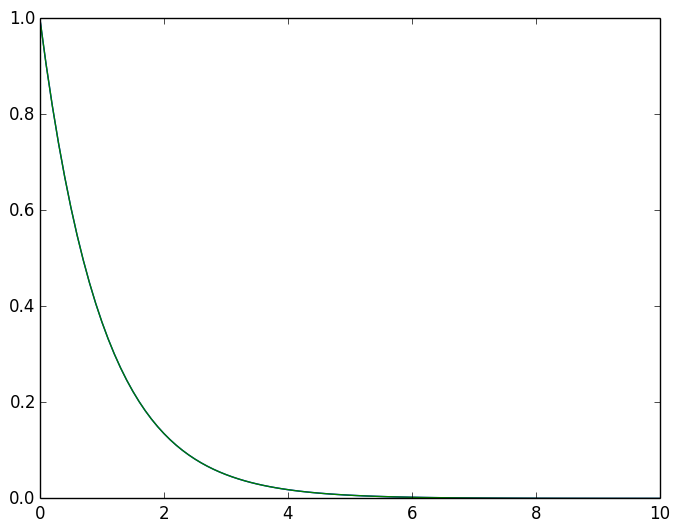

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10b193410>

In [15]:
plot(t, soln)
plot(t, exp(-t))

## Subtle difference from Python

Accessing fields (properties) and methods of Python objects uses the `obj.a` and `obj.b()` syntax, where `obj` is a Python object.
However, currently the `obj.b` syntax in Julia is restricted to accessing fields of Julia composite types.

For this reason, to access fields and methods of Python objects via PyCall, it is necessary to use the syntax

`obj[:a]` for fields, and

`obj[:a]()` for methods

Here, we are using the Julia syntax `:a` to mean the Julia symbol `a`.

## Lower level

The high-level `PyCall` interface is built on top of a lower-level interface which deals with the "transport" of objects between Python and Julia, based on a `PyObject` Julia type that wraps `PyObject*` in C, and represents a reference to a Python object.



In [16]:
PyObject(3)

PyObject 3

In [17]:
x = rand(5, 5)

5x5 Array{Float64,2}:
 0.887502  0.0246364  0.937582  0.684068  0.720231 
 0.384961  0.160604   0.814357  0.827761  0.221047 
 0.125212  0.333403   0.877111  0.949292  0.152891 
 0.782374  0.47016    0.687562  0.846015  0.155578 
 0.827994  0.375204   0.991652  0.79604   0.0131533

In [18]:
xx = PyObject(x)

PyObject array([[ 0.88750169,  0.02463637,  0.93758233,  0.68406787,  0.72023119],
       [ 0.38496148,  0.16060356,  0.81435705,  0.82776091,  0.22104671],
       [ 0.12521248,  0.33340264,  0.87711099,  0.94929151,  0.15289064],
       [ 0.78237384,  0.47015973,  0.68756236,  0.84601514,  0.15557803],
       [ 0.82799391,  0.37520387,  0.99165247,  0.79604021,  0.01315334]])

In [19]:
typeof(xx)

PyObject (constructor with 29 methods)

In [20]:
names(xx)

1-element Array{Symbol,1}:
 :o

In [21]:
xx.o

Ptr{PyObject_struct} @0x00007fdeaf7ccb40

In [11]:
# xx.shape  in Python becomes:
xx[:shape]

(5,5)

In [14]:
typeof(ans)  # the result has already been translated back into a Julia object

(DataType,DataType)

Julia arrays are passed into Python without a copy. By default the resulting Python array is copied when a result is requested in Julia; this can be avoided at a lower level using `pycall` and `PyArray`.

**Exercise**: Use your favourite Python package from Julia!

# Interoperability with C

Julia has a simple way to call C and Fortran functions in shared libraries, via the `ccall` function.

In [25]:
help("ccall")

Base.ccall((symbol, library) or fptr, RetType, (ArgType1, ...), ArgVar1, ...)

   Call function in C-exported shared library, specified by
   "(function name, library)" tuple, where each component is a
   String or :Symbol. Alternatively, ccall may be used to call a
   function pointer returned by dlsym, but note that this usage is
   generally discouraged to facilitate future static compilation. Note
   that the argument type tuple must be a literal tuple, and not a
   tuple-valued variable or expression.


We see that we must specify:

- the name of the function, as a Julia symbol or as a string
- and the name of the shared library where it lives;  these are given as an ordered pair (tuple)


- the return type of the function

- the argument types that the function accepts, as a tuple

- and the arguments themselves

A simple example is to call the clock function:

In [4]:
t = ccall( (:clock, "libc"), Int32, ())

17337016

In [10]:
t

6646395

In [11]:
typeof(t)

Int32

In [36]:
help("ccall")

Base.ccall((symbol, library) or fptr, RetType, (ArgType1, ...), ArgVar1, ...)

   Call function in C-exported shared library, specified by
   "(function name, library)" tuple, where each component is a
   String or :Symbol. Alternatively, ccall may be used to call a
   function pointer returned by dlsym, but note that this usage is
   generally discouraged to facilitate future static compilation. Note
   that the argument type tuple must be a literal tuple, and not a
   tuple-valued variable or expression.


In [ ]:
Clong

In [12]:
path = ccall( (:getenv, "libc"), Ptr{Uint8}, (Ptr{Uint8},), "PATH")

Ptr{Uint8} @0x00007faac9d15f05

Here, `Ptr` denotes a pointer to the given type.

In [31]:
path

Ptr{Uint8} @0x00007fff50e46ed5

In [13]:
bytestring(path)

"/Users/david/development/julia/usr/bin:/Users/david/anaconda/bin:/usr/local/bin:/opt/local/bin:/opt/local/sbin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/bin:/opt/X11/bin:/usr/texbin:.:/Users/david/bin:/Users/david/Dropbox/bin"

In [34]:
?bytestring

Base.bytestring(::Ptr{Uint8}[, length])

   Create a string from the address of a C (0-terminated) string
   encoded in ASCII or UTF-8. A copy is made; the ptr can be safely
   freed. If "length" is specified, the string does not have to be
   0-terminated.

Base.bytestring(s)

   Convert a string to a contiguous byte array representation
   appropriate for passing it to C functions. The string will be
   encoded as either ASCII or UTF-8.


In [37]:
Ptr

Ptr{T}

In [38]:
methods(Ptr)

Ptr{T}

In [39]:
methodswith(Ptr)

58-element Array{Method,1}:
 show{T}(io::IO,p::Ptr{T}) at show.jl:116                                                  
 unsafe_store!{T}(p::Ptr{T},x,i::Integer) at pointer.jl:48                                 
 unsafe_store!{T}(p::Ptr{T},x) at pointer.jl:49                                            
 msync(p::Ptr{T},len::Integer,flags::Integer) at mmap.jl:70                                
 msync(p::Ptr{T},len::Integer) at mmap.jl:72                                               
 integer(x::Ptr{T}) at pointer.jl:55                                                       
 read!(from::IOBuffer,p::Ptr{T},nb::Int64) at iobuffer.jl:70                               
 read!(from::IOBuffer,p::Ptr{T},nb::Integer) at iobuffer.jl:68                             
 show{T}(io::IO,p::Ptr{T}) at show.jl:116                                                  
 -(x::Ptr{T},y::Ptr{T}) at pointer.jl:64                                                   
 -(x::Ptr{T},y::Integer) at pointer.jl:67                                                  
 write(to::IOBuffer,p::Ptr{T},nb::Int64) at iobuffer.jl:237                                
 write(to::IOBuffer,p::Ptr{T},nb::Integer) at iobuffer.jl:235                              
 ⋮                                                                                         
 gzbuffer(gz_file::Ptr{T},gz_buf_size::Integer) at /Users/david/.julia/GZip/src/GZip.jl:197
 show{T}(io::IO,p::Ptr{T}) at show.jl:116                                                  
 write(to::IOBuffer,p::Ptr{T},nb::Int64) at iobuffer.jl:237                                
 write(to::IOBuffer,p::Ptr{T},nb::Integer) at iobuffer.jl:235                              
 write(to::IOBuffer,p::Ptr{T}) at iobuffer.jl:278                                          
 write(s::IOStream,p::Ptr{T},nb::Integer) at iostream.jl:159                               
 write(s::AsyncStream,p::Ptr{T},nb::Integer) at stream.jl:790                              
 write(s::GZipStream,p::Ptr{T},nb::Integer) at /Users/david/.julia/GZip/src/GZip.jl:448    
 write(s::IO,p::Ptr{T},n::Integer) at io.jl:91                                             
 gzwrite(s::GZipStream,p::Ptr{T},len::Integer) at /Users/david/.julia/GZip/src/GZip.jl:184 
 read(from::IOBuffer,p::Ptr{T},nb::Integer) at deprecated.jl:26                            
 PyObject(p::Ptr{T}) at /Users/david/.julia/PyCall/src/conversions.jl:131

In [1]:
type F
    f::Function
    x::Float64
end

In [2]:
hello(x) = x^2

hello (generic function with 1 method)

In [6]:
myfunc = F(hello, 3.5)

F(hello,3.5)

In [4]:
myfunc

LoadError: myfunc not defined
while loading In[4], in expression starting on line 1

In [27]:
myfunc.f

hello (generic function with 1 method)

In [8]:
myfunc.f(myfunc.x)

12.25